# Gaussian Mixture Model

This is tutorial demonstrates how to marginalize out discrete latent variables in Pyro through the motivating example of a mixture model. We'll focus on the mechanics of parallel enumeration, keeping the model simple by training a trivial 1-D Gaussian model on a tiny 5-point dataset. See also the [enumeration tutorial](http://pyro.ai/examples/enumeration.html) for a broader introduction to parallel enumeration.

#### Table of contents

- [Overview](#Overview)
- [Training a MAP estimator](#Training-a-MAP-estimator)
- [Serving the model: predicting membership](#Serving-the-model:-predicting-membership)
  - [Predicting membership using discrete inference](#Predicting-membership-using-discrete-inference)
  - [Predicting membership by enumerating in the guide](#Predicting-membership-by-enumerating-in-the-guide)
- [MCMC](#MCMC)

In [1]:
from functools import reduce

import os
from collections import defaultdict
import torch
import numpy as np
import scipy.stats
from torch.distributions import constraints
from matplotlib import pyplot
%matplotlib inline

import pyro
import pyro.distributions as dist
from pyro import poutine
from pyro.infer.autoguide import AutoDelta
from pyro.optim import Adam
from pyro.infer import SVI, TraceEnum_ELBO, config_enumerate, infer_discrete

smoke_test = ('CI' in os.environ)
assert pyro.__version__.startswith('1.8.0')

from pyro.infer.mcmc.api import MCMC
from pyro.infer.mcmc import NUTS

from itertools import permutations

import os
import os.path as osp
import numpy as np
import matplotlib.pyplot as plt
import pysptools.util as util
import pysptools.eea as eea
import pysptools.abundance_maps as amp

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl

import numpy as np
import pandas as pd
from tqdm import tqdm

import torch
import torch.nn.functional as F
from torch.distributions import constraints

import pyro
from pyro.distributions import *
from pyro.infer import Predictive, SVI, Trace_ELBO
from pyro.optim import Adam

from xrdc import featurization as feat
from xrdc import visualization as vis

from scipy.interpolate import CloughTocher2DInterpolator, NearestNDInterpolator

Loading Data from: /home/ollie/anaconda3/lib/python3.8/site-packages/xrdc-1.0-py3.8.egg/xrdc/inputs/
Data Loaded Succesfully
(177, 800)


## Overview

Pyro's [TraceEnum_ELBO](http://docs.pyro.ai/en/dev/inference_algos.html#pyro.infer.traceenum_elbo.TraceEnum_ELBO) can automatically marginalize out variables in both the guide and the model. When enumerating guide variables, Pyro can either enumerate sequentially (which is useful if the variables determine downstream control flow), or enumerate in parallel by allocating a new tensor dimension and using nonstandard evaluation to create a tensor of possible values at the variable's sample site. These nonstandard values are then replayed in the model. When enumerating variables in the model, the variables must be enumerated in parallel and must not appear in the guide. Mathematically, guide-side enumeration simply reduces variance in a stochastic ELBO by enumerating all values, whereas model-side enumeration avoids an application of Jensen's inequality by exactly marginalizing out a variable.

Here is our tiny dataset. It has five points.

In [3]:
from sklearn.utils import resample

In [4]:
ndim = 2
N = 1000
nphases = 3
T = 3

# weights = Dirichlet(torch.ones(nphases) * .2).expand([N]).sample()

# centers = Normal(0, 1).expand([T, ndim]).sample()

# mixture_centers = torch.matmul(weights, centers)

# X = data = MultivariateNormal(mixture_centers, torch.eye(ndim) / 20).sample()

# #X = data = feat.norm(data)# X / X.abs().mean()


## Training a MAP estimator

Let's start by learning model parameters `weights`, `locs`, and `scale` given priors and data. We will learn point estimates of these using an [AutoDelta](http://docs.pyro.ai/en/dev/infer.autoguide.html#autodelta) guide (named after its delta distributions). Our model will learn global mixture weights, the location of each mixture component, and a shared scale that is common to both components. During inference, [TraceEnum_ELBO](http://docs.pyro.ai/en/dev/inference_algos.html#pyro.infer.traceenum_elbo.TraceEnum_ELBO) will marginalize out the assignments of datapoints to clusters.

In [294]:
# K = T  # Fixed number of components.

# @config_enumerate
# def model(data, scale = .01):
#     # Global variables.
#     weights = pyro.sample('weights', dist.Dirichlet(1 * torch.ones(K)))
    
#     with pyro.plate('dims', ndim):
#         scale = pyro.sample('scale', dist.Uniform(scale * .8, scale * 1.2))#dist.LogNormal(-2.5, 1))

#     with pyro.plate('components', K):
#         locs = pyro.sample('locs', dist.MultivariateNormal(torch.zeros(ndim), torch.eye(ndim)))
#         #print('locs', locs.shape)

#     with pyro.plate('data', N):
#         # Local variables.
#         #assignment = pyro.sample('assignment', dist.Categorical(weights))
#         local_weights = pyro.sample("phase_weights", Dirichlet(weights * alpha))

#         weighted_expectation = torch.einsum('...ji,...j->...i', locs, local_weights)
#         #z = pyro.sample('z', dist.MultivariateNormal(weighted_expectation, torch.eye(ndim) * scale))
#         pyro.sample('obs',
#                     dist.MultivariateNormal(weighted_expectation, torch.eye(ndim) * scale),
#                     obs=data)


#####
# Simple model that allows for covariance between observed dimensions, but uses
# the same covariance for all end members
####
# @config_enumerate
# def model(data, scale = .01):
#     # Global variables.
#     weights = pyro.sample('weights', dist.Dirichlet(1 * torch.ones(K)))
    
#     concentration = torch.ones(
#             ()
#         )
#     # Implies a uniform distribution over correlation matrices
#     L_omega = pyro.sample("L_omega", LKJCholesky(ndim, concentration))
    
#     with pyro.plate('dims', ndim):
#         scale = pyro.sample('scale', dist.Uniform(scale * .8, scale * 1.2))#dist.LogNormal(-2.5, 1))

#     with pyro.plate('components', K):
#         locs = pyro.sample('locs', dist.MultivariateNormal(torch.zeros(ndim), torch.eye(ndim)))
#         #print('locs', locs.shape)

#     with pyro.plate('data', N):
#         # Local variables.
#         #assignment = pyro.sample('assignment', dist.Categorical(weights))
#         local_weights = pyro.sample("phase_weights", Dirichlet(weights * alpha))

#         weighted_expectation = torch.einsum('...ji,...j->...i', locs, local_weights)
        
#         # Lower cholesky factor of the covariance matrix
#         L_Omega = torch.matmul(torch.diag(scale.sqrt()), L_omega)
    
#         #z = pyro.sample('z', dist.MultivariateNormal(weighted_expectation, torch.eye(ndim) * scale))
#         pyro.sample('obs',
#                     dist.MultivariateNormal(weighted_expectation, scale_tril=L_Omega),
#                     obs=data)


alpha = .3
K = T  # Fixed number of components.

params = dict()
#@config_enumerate
def model(data = None, scale = .01, alpha = alpha, covariance = True, alpha_components = 1,
         N = N):
    """
    alpha_components: dirichlet parameter for phase weights
    alpha: dirichlet parameter for phase mixing
    """
    # Global variables.
    weights = pyro.sample('weights', dist.Dirichlet(alpha_components * torch.ones(K)))
    
    concentration = torch.ones(
            ()
        )
    
    with pyro.plate('dims', ndim):
        scale = pyro.sample('scale', dist.Uniform(scale * .5, scale * 1.5))#dist.LogNormal(-2.5, 1))

    with pyro.plate('components', K):
        locs = pyro.sample('locs', dist.MultivariateNormal(torch.zeros(ndim), torch.eye(ndim)))
        
        if covariance:
            # Implies a uniform distribution over correlation matrices
            L_omega = pyro.sample("L_omega", LKJCholesky(ndim, concentration))

    with pyro.plate('data', N):
        # Local variables.
        local_weights = pyro.sample("phase_weights", Dirichlet(weights * alpha))

#         weighted_expectation = pyro.param('weighted_expectation',
#                                     torch.einsum('...ji,...j->...i', locs, local_weights)
#                                          )
        weighted_expectation = torch.einsum('...ji,...j->...i', locs, local_weights)
        params['weighted_expectation'] = weighted_expectation
        
        if covariance:
            # Lower cholesky factor of the covariance matrix
            L_Omega = torch.matmul(torch.diag(scale.sqrt()),
                                   torch.einsum('...jik,...j->...ik', L_omega, local_weights))

            pyro.sample('obs',
                        dist.MultivariateNormal(weighted_expectation, scale_tril=L_Omega),
                        obs=data)
        else:
            pyro.sample('obs',
                dist.MultivariateNormal(weighted_expectation, torch.eye(ndim) * scale),
                obs=data)

In [212]:
Predictive?

In [269]:
alpha

1

In [295]:
# def gen_data(N = N):
#     # Global variables.
#     weights = pyro.sample('weights', dist.Dirichlet(1 * torch.ones(K)))
    
#     concentration = torch.ones(
#             ()
#         )
#     # Implies a uniform distribution over correlation matrices
#     L_omega = pyro.sample("L_omega", LKJCholesky(ndim, concentration))

#     with pyro.plate('dims', ndim):
#         scale = pyro.sample('scale', dist.Uniform(.009, .011))#dist.LogNormal(-2.5, 1))
#         #print('scale', scale, scale.shape)

#     with pyro.plate('components', K):
#         locs = pyro.sample('locs', dist.MultivariateNormal(torch.zeros(ndim), torch.eye(ndim)))
#         #print('locs', locs.shape)

#     with pyro.plate('data', N):
#         # Local variables.
#         #assignment = pyro.sample('assignment', dist.Categorical(weights))
#         local_weights = pyro.sample("phase_weights", Dirichlet(weights * alpha))

#         weighted_expectation = torch.einsum('...ji,...j->...i', locs, local_weights)
        
#         # Lower cholesky factor of the covariance matrix
#         L_Omega = torch.matmul(torch.diag(scale.sqrt()), L_omega)
        
#         #z = pyro.sample('z', dist.MultivariateNormal(weighted_expectation, torch.eye(ndim) * scale))
#         data = dist.MultivariateNormal(weighted_expectation, scale_tril = L_Omega).sample()
#     return weighted_expectation, locs, data

# def gen_data(N = N, alpha = alpha, noise_scale = 1.):
#     alpha_components = 5
#     # Global variables.
#     weights = pyro.sample('weights', dist.Dirichlet(alpha_components * torch.ones(K)))
    
#     concentration = torch.ones(
#             ()
#         )

#     with pyro.plate('dims', ndim):
#         scale = pyro.sample('scale', dist.Uniform(noise_scale * .009, noise_scale * .011))#dist.LogNormal(-2.5, 1))
#         #print('scale', scale, scale.shape)

#     with pyro.plate('components', K):
#         locs = pyro.sample('locs', dist.MultivariateNormal(torch.zeros(ndim), torch.eye(ndim)))

#         # Implies a uniform distribution over correlation matrices
#         L_omega = pyro.sample("L_omega", LKJCholesky(ndim, concentration))
        
#     with pyro.plate('data', N):
#         # Local variables.
#         #assignment = pyro.sample('assignment', dist.Categorical(weights))
#         local_weights = pyro.sample("phase_weights", Dirichlet(weights * alpha))

#         weighted_expectation = torch.einsum('...ji,...j->...i', locs, local_weights)
        
#         # Lower cholesky factor of the covariance matrix
#         L_Omega = torch.matmul(torch.diag(scale.sqrt()),
#                                torch.einsum('...jik,...j->...ik', L_omega, local_weights))
        
#         #z = pyro.sample('z', dist.MultivariateNormal(weighted_expectation, torch.eye(ndim) * scale))
#         data = dist.MultivariateNormal(weighted_expectation, scale_tril = L_Omega).sample()
#     return weighted_expectation, locs, data

def gen_data(N = N, alpha = alpha, noise_scale = .01, alpha_components = 5):
    def _model(*args, **kwargs):
        return model(data = None, scale = noise_scale, alpha = alpha, alpha_components =\
                    alpha_components, N = N)

    prior_samples = Predictive(_model, {}, num_samples=1)()

#     return pyro.get_param_store()['weighted_expectation'].detach(),\
#         prior_samples['locs'][0], prior_samples['obs'][0]
#     return None,\
#         prior_samples['locs'][0], prior_samples['obs'][0]
    return params['weighted_expectation'],\
        prior_samples['locs'][0], prior_samples['obs'][0]

In [261]:
Predictive(model, {}, num_samples=1)()['weights'].shape

torch.Size([1, 1, 3])

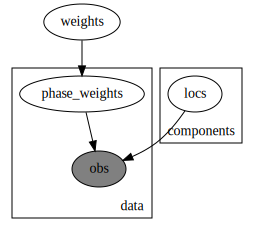

In [50]:
pyro.render_model(model, model_args=(data,))

standard GMM

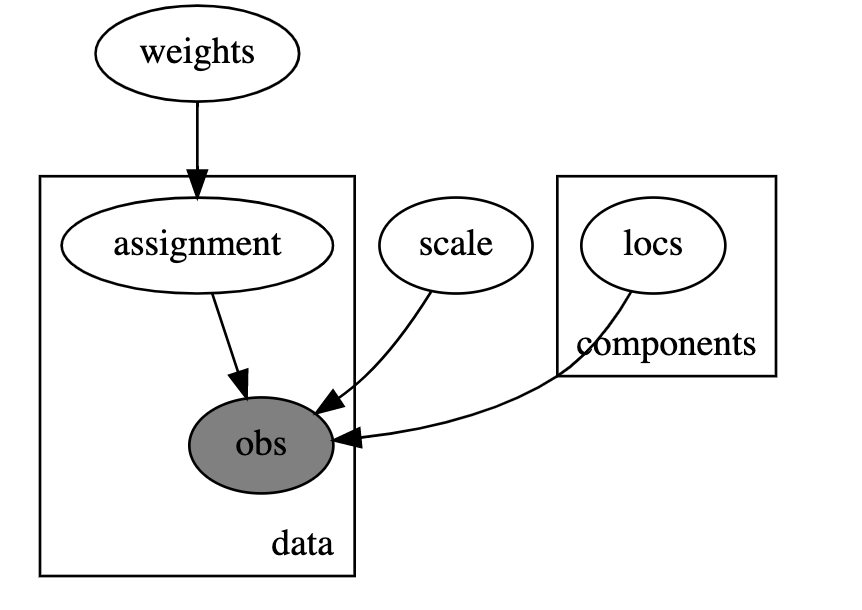

compositional GMM

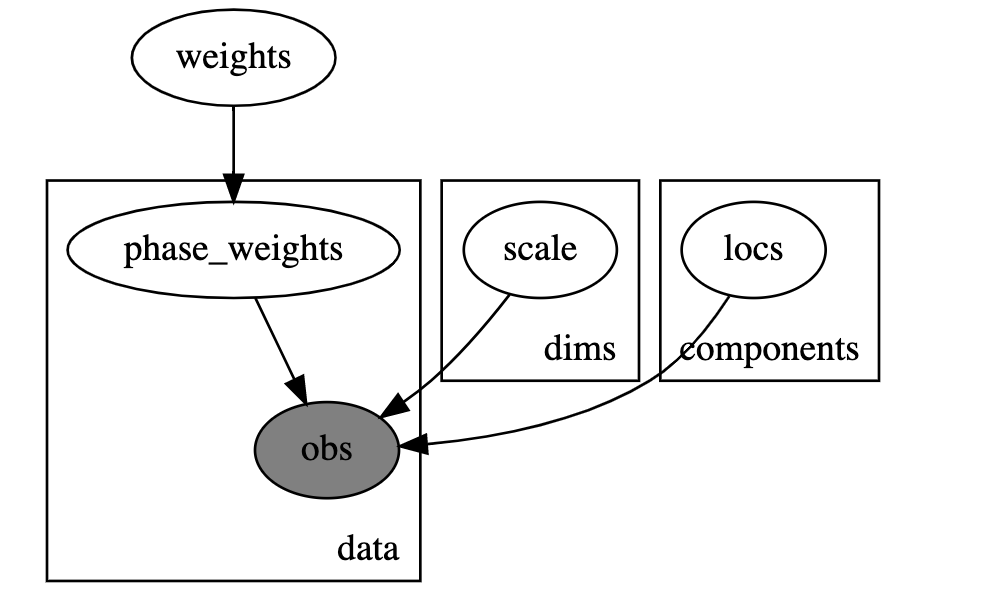

<AxesSubplot:>

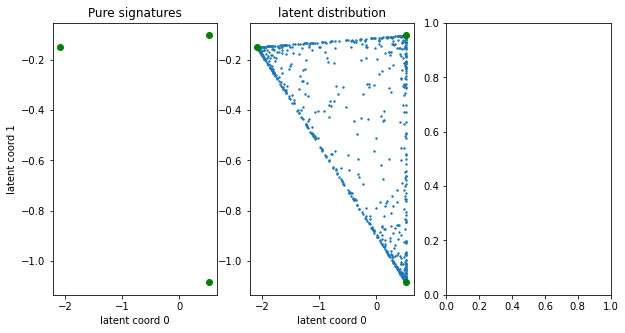

In [198]:
import matplotlib as mpl

mpl.rcParams['figure.figsize'] =(10,5)
alpha = 1

pyro.set_rng_seed(14)

we, loc, dat  = gen_data(1000, alpha = .5)
a, b = 1, 3

plt.subplot(a, b, 1)
plt.xlabel('latent coord 0')
plt.ylabel('latent coord 1')
plt.scatter(*loc.T, c = 'green')
plt.title('Pure signatures')

plt.subplot(a, b, 2)
plt.xlabel('latent coord 0')
plt.scatter(*we.T, s = 2)
plt.scatter(*loc.T, c = 'green')
plt.title('latent distribution')

plt.subplot(a, b, 3)
# plt.xlabel('latent coord 0')
# plt.scatter(*dat.T, s = 2)
# plt.scatter(*loc.T, c = 'green')
# plt.title('observations')

Text(0.5, 1.0, 'observations')

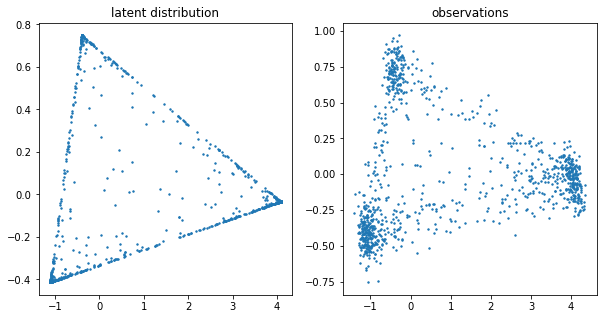

In [297]:
# TODO it's possible (though I think unlikely, because qualitative results are the same)
# that the refactor of gen_data changed its behavior
import matplotlib as mpl

mpl.rcParams['figure.figsize'] =(10,5)
alpha = 1

pyro.set_rng_seed(15)

we, _, dat = gen_data(1000, noise_scale=.01)
a, b = 1, 2
plt.subplot(a, b, 1)
plt.scatter(*we.T, s = 2)
plt.title('latent distribution')

plt.subplot(a, b, 2)
plt.scatter(*dat.T, s = 2)
plt.title('observations')

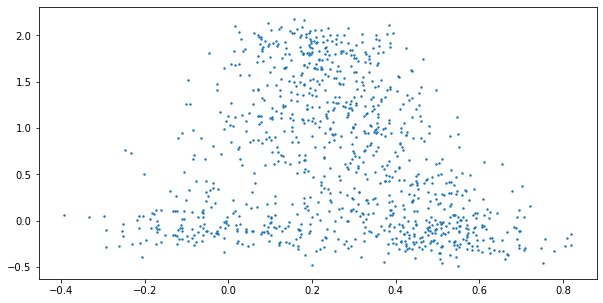

In [98]:
plt.scatter(*data.T, s = 2)
#plt.scatter(*local_weights[:, :2].T, s = 1)

In [25]:
%pdb

Automatic pdb calling has been turned OFF


## MCMC

Next we'll explore the full posterior over component parameters using collapsed NUTS, i.e. we'll use NUTS and marginalize out all discrete latent variables.

In [162]:
num_samples = 50


from pyro.infer.mcmc.api import MCMC
from pyro.infer.mcmc import NUTS
pyro.set_rng_seed(3)
kernel = NUTS(model)
mcmc = MCMC(kernel, num_samples=num_samples, warmup_steps=50)
mcmc.run(data)
posterior_samples = mcmc.get_samples()

Sample: 100%|██████████| 100/100 [01:27,  1.14it/s, step size=3.42e-02, acc. prob=0.042]


In [163]:
components = [posterior_samples["locs"][:, i, :] for i in range(T)]

<IPython.core.display.Javascript object>


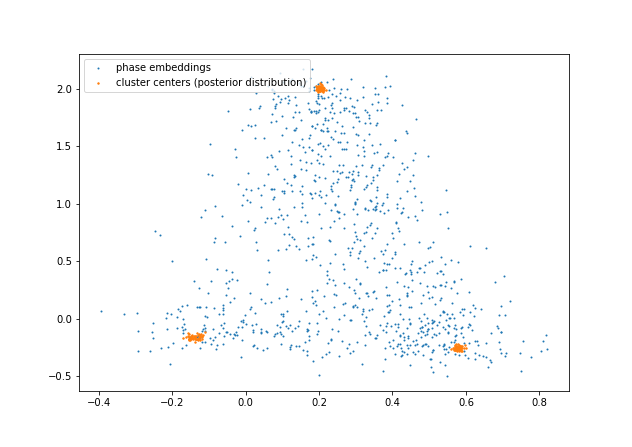

(tensor([0.2671, 0.0989, 0.6340]), tensor([0.3778, 0.3744, 0.2477]))

In [109]:
%matplotlib notebook

plt.scatter(*(data).T, s = 1, label = 'phase embeddings')
plt.scatter(*torch.vstack(components).T, s = 2, label = 'cluster centers (posterior distribution)')
#plt.scatter(*locs.T, label = 'cluster centers (ground truth)')
plt.legend(loc = 'upper left')
#plt.scatter(*np.array(local_weights[:, :2].T), s = 1)

weights, posterior_samples["weights"].mean(axis = 0)

In [45]:
%matplotlib notebook

plt.scatter(*(data).T, s = 1, label = 'phase embeddings')
plt.scatter(*torch.vstack(components).T, s = 2, label = 'cluster centers (inferred posterior distribution)')
plt.scatter(*locs.T, label = 'cluster centers (ground truth)')
plt.legend()
#plt.scatter(*np.array(local_weights[:, :2].T), s = 1)

weights, posterior_samples["weights"].mean(axis = 0)

<IPython.core.display.Javascript object>

(tensor([0.2671, 0.0989, 0.6340]), tensor([0.2834, 0.2218, 0.4948]))

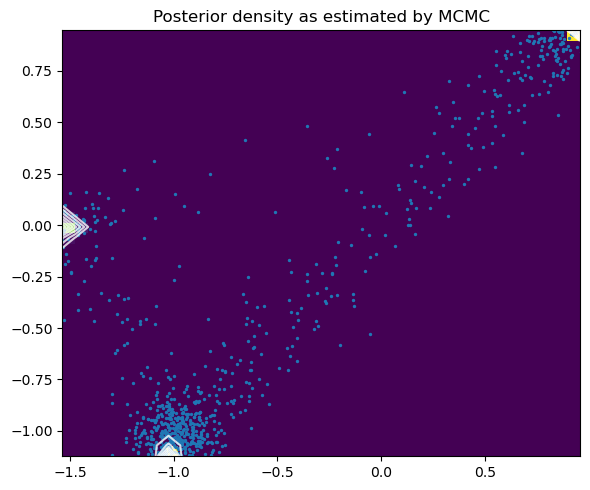

In [63]:
%matplotlib inline

# plt.scatter(*(data).T, s = 1, label = 'phase embeddings')
# plt.scatter(*torch.vstack(components).T, s = 2, label = 'cluster centers (inferred posterior distribution)')
# plt.scatter(*locs.T, label = 'cluster centers (ground truth)')
# plt.legend()
# #plt.scatter(*np.array(local_weights[:, :2].T), s = 1)

# weights, posterior_samples["weights"].mean(axis = 0)


pyplot.figure(figsize=(6, 5), dpi=100).set_facecolor('white')

#XX, YY = components[i].T
XX, YY = torch.vstack(components).T
h, xs, ys, image = pyplot.hist2d(XX.numpy(), YY.numpy(), bins=[40, 40])
pyplot.contour(np.log(h + 3).T, extent=[xs.min(), xs.max(), ys.min(), ys.max()],
               colors='white', alpha=0.8)
pyplot.title('Posterior density as estimated by MCMC')

plt.scatter(*np.array(data.T), s = 2)

pyplot.tight_layout()

Note that due to nonidentifiability of the mixture components the likelihood landscape has two equally likely modes, near `(11,0.5)` and `(0.5,11)`. NUTS has difficulty switching between the two modes.

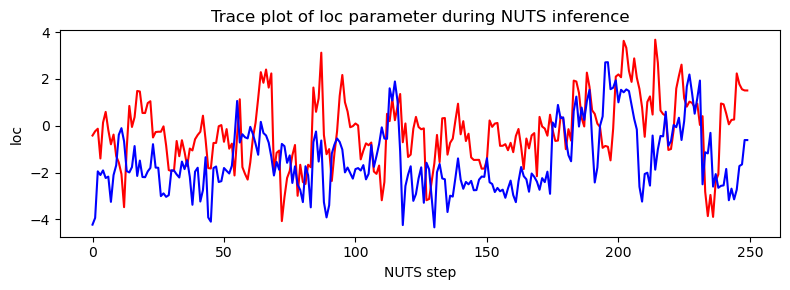

In [115]:
pyplot.figure(figsize=(8, 3), dpi=100).set_facecolor('white')
pyplot.plot(XX.numpy(), color='red')
pyplot.plot(YY.numpy(), color='blue')
pyplot.xlabel('NUTS step')
pyplot.ylabel('loc')
pyplot.title('Trace plot of loc parameter during NUTS inference')
pyplot.tight_layout()

In [460]:
import matplotlib as mpl

N = 1000

mpl.rcParams['figure.figsize'] =(10,5)


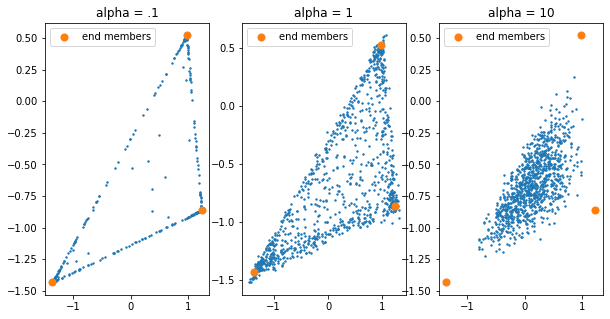

In [101]:
N = 1000

pyro.set_rng_seed(3)
we, locs, data = gen_data(N, alpha = .1, noise_scale=.2)

a, b = 1, 3
plt.subplot(a, b, 1)
plt.scatter(*we.T, s = 2)
plt.scatter(*(locs.T), s = 50, label = 'end members')
plt.title('alpha = .1')
plt.legend()

pyro.set_rng_seed(3)
we, locs, data = gen_data(N, alpha = 1, noise_scale=.2)

plt.subplot(a, b, 2)
plt.scatter(*data.T, s = 2)
plt.scatter(*(locs.T), s = 50, label = 'end members')
plt.title('alpha = 1')
plt.legend()

pyro.set_rng_seed(3)
we, locs, data = gen_data(N, alpha = 10, noise_scale=.2)

plt.subplot(a, b, 3)
plt.scatter(*data.T, s = 2)
plt.scatter(*(locs.T), s = 50, label = 'end members')
# plt.scatter(*(nfindr_locs(data).T), s = 50, label = 'N-FINDR')
plt.title('alpha = 10')
plt.legend()

## High concentration:

In [ ]:
mark

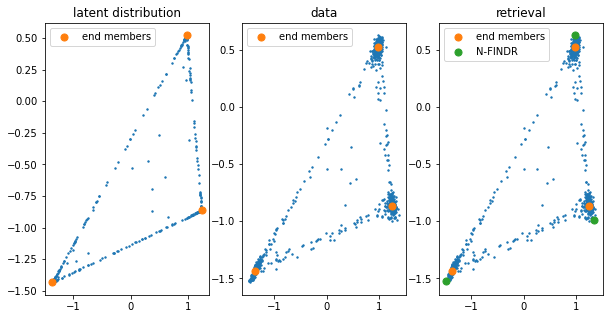

In [102]:
N = 1000

pyro.set_rng_seed(3)

alpha = .1

we, locs, data = gen_data(N, alpha = alpha, noise_scale=.2)

a, b = 1, 3
plt.subplot(a, b, 1)
plt.scatter(*we.T, s = 2)
plt.scatter(*(locs.T), s = 50, label = 'end members')
plt.title('latent distribution')
plt.legend()

plt.subplot(a, b, 2)
plt.scatter(*data.T, s = 2)
plt.scatter(*(locs.T), s = 50, label = 'end members')
plt.title('data')
plt.legend()

plt.subplot(a, b, 3)
plt.scatter(*data.T, s = 2)
plt.scatter(*(locs.T), s = 50, label = 'end members')
plt.scatter(*(nfindr_locs(data).T), s = 50, label = 'N-FINDR')
plt.title('retrieval')
plt.legend()

## Low concentration:

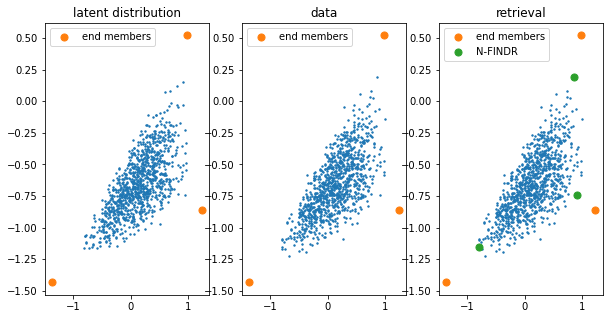

In [103]:
N = 1000

pyro.set_rng_seed(3)

alpha = 10

we, locs, data = gen_data(N, alpha=alpha, noise_scale = .2)

a, b = 1, 3
plt.subplot(a, b, 1)
plt.scatter(*we.T, s = 2)
plt.scatter(*(locs.T), s = 50, label = 'end members')
plt.title('latent distribution')
plt.legend()

plt.subplot(a, b, 2)
plt.scatter(*data.T, s = 2)
plt.scatter(*(locs.T), s = 50, label = 'end members')
plt.title('data')
plt.legend()

plt.subplot(a, b, 3)
plt.scatter(*data.T, s = 2)
plt.scatter(*(locs.T), s = 50, label = 'end members')
plt.scatter(*(nfindr_locs(data).T), s = 50, label = 'N-FINDR')
plt.title('retrieval')
plt.legend()

### Low concentration, high noise

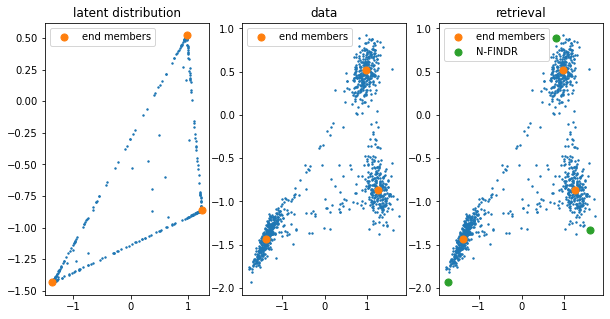

In [124]:
N = 1000

pyro.set_rng_seed(3)

alpha = .1

we, locs, data = gen_data(N, alpha = alpha, noise_scale=3)

a, b = 1, 3
plt.subplot(a, b, 1)
plt.scatter(*we.T, s = 2)
plt.scatter(*(locs.T), s = 50, label = 'end members')
plt.title('latent distribution')
plt.legend()

plt.subplot(a, b, 2)
plt.scatter(*data.T, s = 2)
plt.scatter(*(locs.T), s = 50, label = 'end members')
plt.title('data')
plt.legend()

plt.subplot(a, b, 3)
plt.scatter(*data.T, s = 2)
plt.scatter(*(locs.T), s = 50, label = 'end members')
plt.scatter(*(nfindr_locs(data).T), s = 50, label = 'N-FINDR')
plt.title('retrieval')
plt.legend()

In [ ]:
mark2

In [153]:
%matplotlib inline
mpl.rcParams['figure.figsize'] =(10,8)


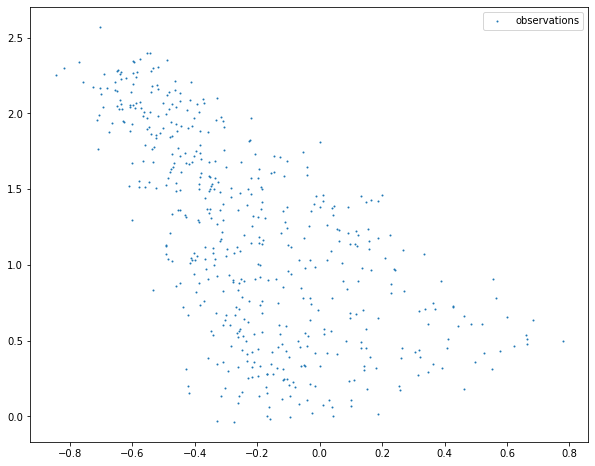

In [157]:
i = 130
data, components, locs = res[i]['data'], res[i]['components'], res[i]['locs']

plt.scatter(*(data).T, s = 1, label = 'observations')
# plt.scatter(*(locs.T), s = 50, label = 'ground truth')
# plt.scatter(*torch.vstack(components).T, s = 2, label = 'cluster centers (posterior samples)')
# plt.scatter(*(nfindr_locs(data).T), s = 50, label = 'N-FINDR')

#plt.scatter(*locs.T, label = 'cluster centers (ground truth)')
plt.legend()#loc = 'upper left')
#plt.scatter(*np.array(local_weights[:, :2].T), s = 1)


In [229]:
alpha = 1

def f(*args):
    return model(*args, scale = .01)

kernel = NUTS(f)
mcmc = MCMC(kernel, num_samples=num_samples, warmup_steps=50)
mcmc.run(data2)
posterior_samples = mcmc.get_samples()

components = [posterior_samples["locs"][:, i, :] for i in range(T)]

Sample: 100%|██████████| 100/100 [01:54,  1.15s/it, step size=2.49e-02, acc. prob=0.952]


In [ ]:
components = [posterior_samples["locs"][:, i, :] for i in range(T)]

In [466]:
posterior_samples["locs"].swapaxes(0, 1)

torch.Size([3, 50, 2])

In [464]:
posterior_samples["locs"]

torch.Size([50, 3, 2])

<IPython.core.display.Javascript object>


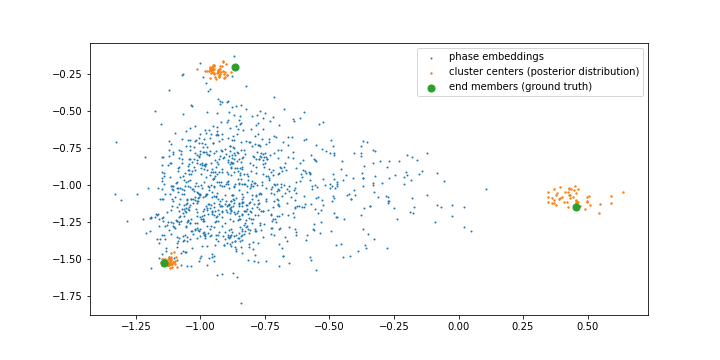

(tensor([0.2671, 0.0989, 0.6340]), tensor([0.3302, 0.5220, 0.1478]))

In [216]:
%matplotlib notebook

plt.scatter(*(data2).T, s = 1, label = 'phase embeddings')
plt.scatter(*torch.vstack(components).T, s = 2, label = 'cluster centers (posterior distribution)')
plt.scatter(*(locs.T), s = 50, label = 'end members (ground truth)')

#plt.scatter(*locs.T, label = 'cluster centers (ground truth)')
plt.legend(loc = 'upper right')
#plt.scatter(*np.array(local_weights[:, :2].T), s = 1)

weights, posterior_samples["weights"].mean(axis = 0)

## Workflow week of 4/17

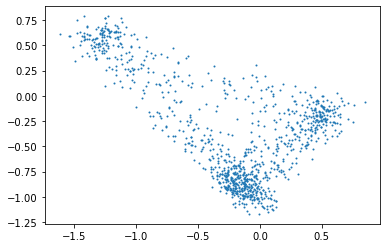

In [8]:
N = 1000

# mpl.rcParams['figure.figsize'] =(10,5)
alpha = .5

we, locs, data = gen_data(N)

plt.scatter(*(data).T, s = 1, label = 'phase embeddings')


In [194]:
def rms(arr):
    arr = np.array(arr)
    return np.sqrt((arr**2).sum() / len(arr))

def loc_stds(component_locs):
    return np.sqrt((component_locs.std(axis = 0)**2).sum() / component_locs.shape[1])

def loc_means(component_locs):
    return component_locs.mean(axis = 0)

alpha = 1
num_samples = 50
N = 500

# mpl.rcParams['figure.figsize'] =(10,5)
#alpha = .5
pyro.set_rng_seed(3)

def closest_permutation_diffs(locs_posterior_means, locs):
    # Figure out mapping from ground truth end members to inferred end members
    clust_permutations = list(permutations(np.arange(T), r = T))
    permutation_norms = [np.linalg.norm(locs_posterior_means[ci_permute, :] - np.array(locs))
                         for ci_permute in clust_permutations]
    best_permutation = clust_permutations[np.argmin(permutation_norms)]

    locs_diffs = locs_posterior_means[best_permutation, :] - np.array(locs)
    return locs_diffs

def get_beta(va, vb, vc, norm = True):
    # area of the simplex drawn by the endmember coordinates, relative to that of the regular simplex
    vmean = reduce(lambda a, b: a + np.linalg.norm(b),
                   [vb - va, vc - vb, va - vc], 0) / 3
    ref_area = np.sqrt(3) * vmean**2 / 4 # area of equal-surface regular simplex
    beta = np.abs(np.cross((vb - va), (vc - va)))
    if norm:
        beta /= (2 * ref_area)
    return beta


def run_instance(alpha, datadict = None, num_samples = 50, N = 500, noise_scale = 1):
    """
    If datadict is provided, use it as observations. Otherwise generate using the given
    alpha, noise_scale and N
    """
    # set this if you want the same cluster params independent of alpha
    #pyro.set_rng_seed(3)

    if datadict is None:
        we, locs, data = gen_data(N, alpha = alpha, noise_scale = noise_scale)
    else:
        we, locs, data = datadict['we'], datadict['locs'], datadict['data']

    def f(*args):
        return model(*args, scale = .01, alpha = alpha)

    kernel = NUTS(f)
    mcmc = MCMC(kernel, num_samples=num_samples, warmup_steps=50)
    mcmc.run(data)
    posterior_samples = mcmc.get_samples()

    components = [posterior_samples["locs"][:, i, :] for i in range(T)]

    posterior_locs = np.array(posterior_samples["locs"])
    locs_posterior_means = np.vstack([loc_means(posterior_locs[:, i, :]) for i in range(posterior_locs.shape[1])])

    # TODO generalize
    va, vb, vc = locs
    beta = get_beta(va, vb, vc)

    rms_locs = rms([loc_stds(posterior_locs[:, i, :]) for i in range(posterior_locs.shape[1])])

    # TODO refactor
    # Figure out mapping from ground truth end members to inferred end members
    clust_permutations = list(permutations(np.arange(T), r = T))
    permutation_norms = [np.linalg.norm(locs_posterior_means[ci_permute, :] - np.array(locs))
                         for ci_permute in clust_permutations]
    best_permutation = clust_permutations[np.argmin(permutation_norms)]

    locs_diffs = locs_posterior_means[best_permutation, :] - np.array(locs)

    result_dict = {'data': data, 'locs': locs, 'samples': posterior_samples, 'rms_locs': rms_locs,
                   'diff_locs': locs_diffs, 'permutation': best_permutation, 'alpha': alpha, 'beta': beta,
                  'components': components, 'latents': we, 'noise_scale': noise_scale}
    return result_dict

def nfindr_locs(data):
    data = np.array(data).copy()
    data = np.array(data)[:, None, :]
    #print(data.shape)
    nfindr = eea.NFINDR()
    U = nfindr.extract(data, T, maxit = 1500, normalize=False, ATGP_init=False)
    return U

def score_nfindr(elt):
    """
    Get end members using nfindr and return the endmember coordinate errors
    """
#     posterior_samples = elt['samples']
    locs = elt['locs']
    data = elt['data']
    
#     components = [posterior_samples["locs"][:, i, :] for i in range(T)]
    
#     posterior_locs = np.array(posterior_samples["locs"])
#     locs_posterior_means = np.vstack([loc_means(posterior_locs[:, i, :]) for i in range(posterior_locs.shape[1])])

    for _ in range(1000):
        try:
            #U = nfindr_locs(data)
            U = get_max(nfindr_locs, lambda inp: get_beta(*inp, norm=False), data)
            break
        except ValueError:
            pass
    return closest_permutation_diffs(U, locs)

def plotnfindr(i, save = False, xlim = None, ylim = None):
    U= get_max(nfindr_locs, lambda inp: get_beta(*inp, norm = False), res_noise[i]['data'])
    #U = nfindr_locs(res_noise[i]['data'])
    plt.scatter(*(res_noise[i]['data']).T, s = 1, label = 'phase embeddings')
    plt.scatter(*(res_noise[i]['locs'].T), s = 50, label = 'end members (ground truth)')
    plt.scatter(*U.T, label = 'nfindr')

    plt.legend(loc = 'upper left')
    #plt.title('alpha = {:.2f}; beta = {:.2f}'.format(alphas[i], betas[i]))
    if xlim:
        plt.xlim(xlim)
    if ylim:
        plt.ylim(ylim)
    if save:
        plt.savefig('data/figs/{}.png'.format(i))
    
def get_max(f, metric, *args, attempts = 1):
    res = []
    for _ in range(attempts):
        out = f(*args)
        score = metric(out)
        res.append((score, out))
#     print(res)
#     print(sorted(res))
    best = sorted(res, key = lambda tup: tup[0])[-1]
    #print(best[0])
    return best[1]

In [175]:
plt.savefig?

In [163]:
torch.set_num_threads(12)
torch.get_num_threads()

12

In [189]:
# alphas = np.logspace(-1, 1, 200)
# res = []
# for a in alphas:
#     res.append(run_instance(a, num_samples = 50, N = 500))

In [230]:
from importlib import reload
reload(vis)

<module 'xrdc.visualization' from '/home/ollie/anaconda3/lib/python3.8/site-packages/xrdc-1.0-py3.8.egg/xrdc/visualization.py'>

In [105]:
def ploti(i):
    plt.scatter(*(res[i]['data']).T, s = 1, label = 'phase embeddings')
    plt.scatter(*torch.vstack(res[i]['components']).T, s = 2, label = 'cluster centers (posterior samples)')
    
    plt.scatter(*(res[i]['locs'].T), s = 50, label = 'end members (ground truth)')
    
    post_loc_centroids = np.vstack([comp.mean(axis = 0) for comp in res[i]['components']])
    plt.scatter(*post_loc_centroids.T, c = 'k', s = 50, label = 'end members (posterior sample centroids)')

    plt.legend()
    plt.title('alpha = {:.2f}; beta = {:.2f}'.format(alphas[i], betas[i]))

In [160]:
def ploti2(i, save = False, xlim = None, ylim = None):
    locs = res[i]['locs']
    data = res[i]['data']
    plt.scatter(*(data).T, s = 1, label = 'observations')
    plt.scatter(*torch.vstack(res[i]['components']).T, s = 2, label = 'cluster centers (posterior samples)')
    
    plt.scatter(*(locs.T), s = 50, label = 'ground truth')
    
    post_loc_centroids = np.vstack([comp.mean(axis = 0) for comp in res[i]['components']])
    plt.scatter(*post_loc_centroids.T, c = 'k', s = 50, label = 'end members (posterior sample centroids)')
    plt.scatter(*(nfindr_locs(data).T), s = 50, label = 'N-FINDR')


    plt.legend(loc = 'upper left')
    #plt.title('alpha = {:.2f}; beta = {:.2f}'.format(alphas[i], betas[i]))
    if xlim:
        plt.xlim(xlim)
    if ylim:
        plt.ylim(ylim)
    if save:
        plt.savefig('data/figs/{}.png'.format(i))
    #plt.title('alpha = {:.2f}; beta = {:.2f}'.format(alphas[i], betas[i]))
    
# def plotnfindr(i, save = False, xlim = None, ylim = None):
#     U= get_max(nfindr_locs, lambda inp: get_beta(*inp, norm = False), res_noise[i]['data'])
#     #U = nfindr_locs(res_noise[i]['data'])
#     plt.scatter(*(res_noise[i]['data']).T, s = 1, label = 'phase embeddings')
#     plt.scatter(*(res_noise[i]['locs'].T), s = 50, label = 'end members (ground truth)')
#     plt.scatter(*U.T, label = 'nfindr')

#     plt.legend(loc = 'upper left')
#     #plt.title('alpha = {:.2f}; beta = {:.2f}'.format(alphas[i], betas[i]))
#     if xlim:
#         plt.xlim(xlim)
#     if ylim:
#         plt.ylim(ylim)
#     if save:
#         plt.savefig('data/figs/{}.png'.format(i))

In [106]:
from xrdc import source_separation as sep

In [107]:
# notable examples: 194, 
%matplotlib inline
vis.iplot(ploti, res)

interactive(children=(IntSlider(value=99, description='i', max=199), Output(layout=Layout(height='550px'))), _…

In [161]:
# notable examples: 194, 
%matplotlib inline
vis.iplot(ploti2, res)

interactive(children=(IntSlider(value=99, description='i', max=199), Output(layout=Layout(height='550px'))), _…

In [169]:
va, vb, vc = res[3]['locs']

In [170]:
# vmean = reduce(lambda a, b: a + np.linalg.norm(b), [vb - va, vc - vb, va - vc], 0) / 3
# ref_area = np.sqrt(3) * vmean**2 / 4
# beta = np.abs(np.cross((vb - va), (vc - va)) / (2 * ref_area))

In [206]:
res[0].keys()

dict_keys(['data', 'locs', 'samples', 'rms_locs', 'diff_locs', 'permutation', 'alpha', 'beta', 'components'])

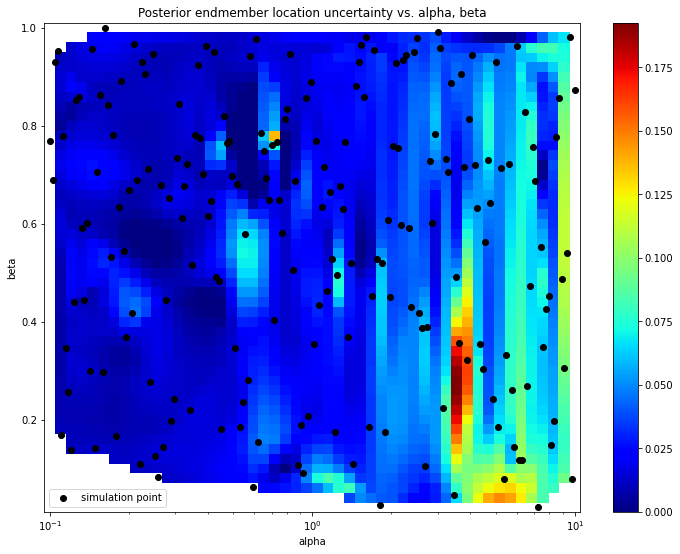

In [258]:
betas = np.array([elt['beta'] for elt in res])


x = alphas
y = betas
z = np.array([elt['rms_locs'] for elt in res])

X = np.logspace(np.log10(min(x)), np.log10(max(x)))
Y = np.linspace(min(y), max(y))
X, Y = np.meshgrid(X, Y)  # 2D grid for interpolation
interp = CloughTocher2DInterpolator(list(zip(x, y)), z)
#interp = NearestNDInterpolator(list(zip(x, y)), z)
Z = interp(X, Y)
plt.title("Posterior endmember location uncertainty vs. alpha, beta")
plt.pcolormesh(X, Y, Z, shading='auto', cmap = 'jet', vmin = 0)
plt.plot(x, y, "ok", label="simulation point")
plt.legend()
plt.colorbar()
#plt.axis("equal")
plt.xlabel('alpha')
plt.ylabel('beta')
plt.semilogx()
plt.show()

In [211]:
np.linalg.norm(res[0]['diff_locs'])

0.099819675

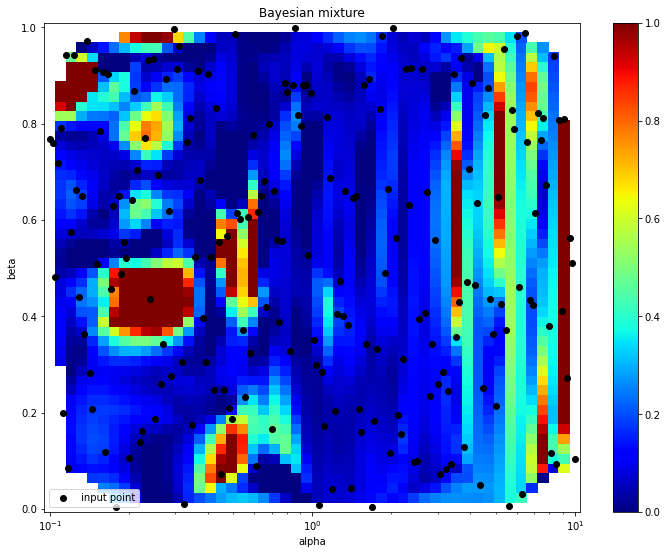

In [40]:
x = alphas
y = betas
z = np.array([np.linalg.norm(elt['diff_locs']) for elt in res])

X = np.logspace(np.log10(min(x)), np.log10(max(x)))
Y = np.linspace(min(y), max(y))
X, Y = np.meshgrid(X, Y)  # 2D grid for interpolation
interp = CloughTocher2DInterpolator(list(zip(x, y)), z)
#interp = NearestNDInterpolator(list(zip(x, y)), z)
Z = interp(X, Y)
plt.pcolormesh(X, Y, Z, shading='auto', cmap = 'jet', vmin = 0, vmax = 1)
plt.plot(x, y, "ok", label="input point")
plt.legend()
plt.colorbar()
#plt.axis("equal")
plt.xlabel('alpha')
plt.ylabel('beta')
plt.title('Bayesian mixture')
plt.semilogx()
plt.show()

In [469]:
# component_locs = np.array(posterior_samples["locs"][:, 0, :])

In [479]:
# loc_stds = np.sqrt((component_locs.std(axis = 0)**2).sum() / component_locs.shape[1])

In [231]:
posterior_samples.keys()

dict_keys(['L_omega', 'locs', 'phase_weights', 'scale', 'weights'])

In [12]:
from xrdc import misc

In [414]:
from importlib import reload
reload(misc)

with open('data/synthetic_simple.npy', 'rb') as f:
    patterns_pp = np.load(f)

In [415]:
with open('data/synthetic_mask.npy', 'rb') as f:
    mask = np.load(f)

In [416]:
with open('data/synthetic_simple_composition.npy', 'rb') as f:
    composition = np.load(f).reshape(patterns_pp.shape[:2] + (-1,))[mask]

In [417]:
composition.shape

(93, 3)

In [418]:
patterns_pp.shape

(15, 15, 43)

In [423]:
X = patterns_pp[mask]#.reshape(-1, 33)

#X += 100 * np.random.normal(size = X.shape)

#X = X / (np.std(X, axis = 0))
X = torch.from_numpy(X)

from sklearn.decomposition import PCA

pca = PCA(n_components=ndim, svd_solver = 'arpack')
Xpca = pca.fit_transform(X)

Xpca -= Xpca.mean(axis = 0)
Xpca /= Xpca.std(axis = 0)

In [385]:
# i = 0
# U,S,V = torch.linalg.svd(X, full_matrices = False)
# eigvecs=U.t()[:, i:ndim + i] #the first k vectors will be kept
# y=torch.mm(U,eigvecs)

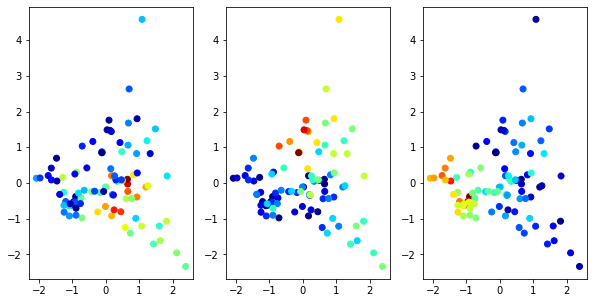

In [420]:
a, b = 1, 3

plt.subplot(a,b, 1)
plt.scatter(*(Xpca.T), c = composition[:, 0], cmap = 'jet')

plt.subplot(a,b, 2)
plt.scatter(*(Xpca.T), c = composition[:, 1], cmap = 'jet')

plt.subplot(a, b, 3)
plt.scatter(*(Xpca.T), c = composition[:, 2], cmap = 'jet')

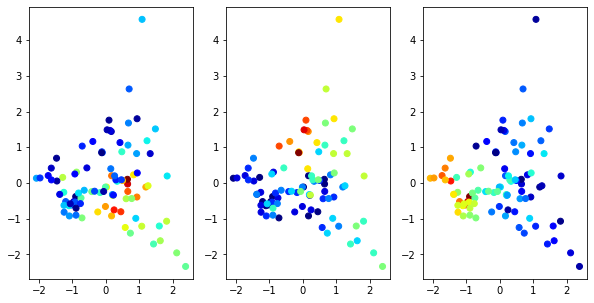

In [430]:
a, b = 1, 3

plt.subplot(a,b, 1)
plt.scatter(*(Xpca.T), c = composition[:, 0], cmap = 'jet')

plt.subplot(a,b, 2)
plt.scatter(*(Xpca.T), c = composition[:, 1], cmap = 'jet')

plt.subplot(a, b, 3)
plt.scatter(*(Xpca.T), c = composition[:, 2], cmap = 'jet')

In [424]:
Xpca = torch.from_numpy(Xpca.copy())
Xpca = Xpca.type(torch.float32)

In [437]:
alpha = 1
N = 93
num_samples = 50

def f(*args):
    return model(*args, scale = .2)

from pyro.infer.mcmc.api import MCMC
from pyro.infer.mcmc import NUTS
pyro.set_rng_seed(3)
kernel = NUTS(model)
mcmc = MCMC(kernel, num_samples=num_samples, warmup_steps=50)
mcmc.run(Xpca)
posterior_samples = mcmc.get_samples()

components = [posterior_samples["locs"][:, i, :] for i in range(T)]

Sample: 100%|██████████| 100/100 [01:55,  1.16s/it, step size=8.80e-03, acc. prob=0.908]


In [390]:
cimax, cjmax, ckmax = composition[:, 0].argmax(), composition[:, 1].argmax(), composition[:, 2].argmax()

In [393]:
composition[[cimax, cjmax, ckmax]], Xpca[[cimax, cjmax, ckmax]]

(array([[1.        , 0.        , 0.        ],
        [0.00512834, 0.98974332, 0.00512834],
        [0.        , 0.        , 1.        ]]),
 tensor([[2.0211, 0.5490],
         [0.0481, 0.5073],
         [2.0211, 0.5490]]))

tensor([0.3955, 0.3592, 0.2452])

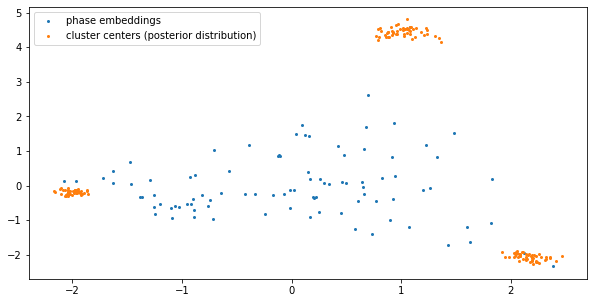

In [438]:
%matplotlib inline
mpl.rcParams['figure.figsize'] =(10,5)

plt.scatter(*(Xpca).T, s = 4, label = 'phase embeddings')
plt.scatter(*torch.vstack(components).T, s = 4, label = 'cluster centers (posterior distribution)')
plt.legend(loc = 'upper left')

#plt.scatter(*(Xpca[[cimax, cjmax, ckmax]].T), s = 50, label = 'end members (ground truth)')
posterior_samples["weights"].mean(axis = 0)

tensor([0.3934, 0.3600, 0.2466])

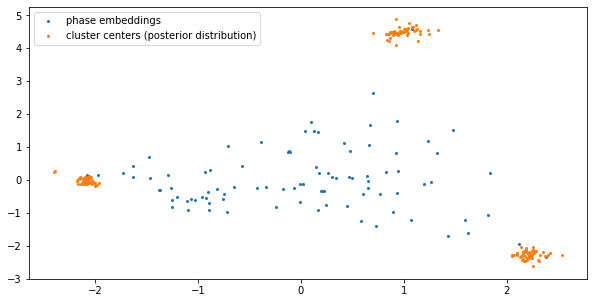

In [428]:
%matplotlib inline
mpl.rcParams['figure.figsize'] =(10,5)

plt.scatter(*(Xpca).T, s = 4, label = 'phase embeddings')
plt.scatter(*torch.vstack(components).T, s = 4, label = 'cluster centers (posterior distribution)')
plt.legend(loc = 'upper left')


#plt.scatter(*(Xpca[[cimax, cjmax, ckmax]].T), s = 50, label = 'end members (ground truth)')
posterior_samples["weights"].mean(axis = 0)

tensor([0.2710, 0.5233, 0.2057])

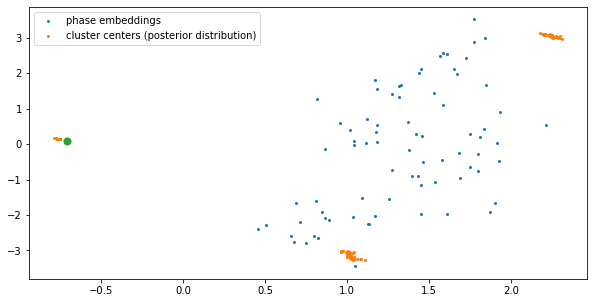

In [353]:
%matplotlib inline
mpl.rcParams['figure.figsize'] =(10,5)

plt.scatter(*(Xpca).T, s = 4, label = 'phase embeddings')
plt.scatter(*torch.vstack(components).T, s = 4, label = 'cluster centers (posterior distribution)')
plt.legend(loc = 'upper left')


plt.scatter(*(Xpca[[cjmax]].T), s = 50, label = 'end members (ground truth)')
posterior_samples["weights"].mean(axis = 0)

In [361]:
Xpca[[cimax, cjmax, ckmax]]

tensor([[-0.7084,  0.0887],
        [-0.7084,  0.0887],
        [-0.7084,  0.0887]])

In [363]:
composition[[cimax, cjmax, ckmax]]

array([[ 1.        ,  0.        ,  0.        ],
       [-0.57735027,  1.15470054,  0.42264973],
       [ 0.        ,  0.        ,  1.        ]])

In [398]:
Xpca.shape

torch.Size([93, 2])

In [355]:
cimax

14

In [259]:
"""
Plot abundance maps stack for the methanol gas HSI cube.
"""

from __future__ import print_function

# import os
# import os.path as osp
# import numpy as np
# import matplotlib.pyplot as plt
# import pysptools.util as util
# import pysptools.eea as eea
# import pysptools.abundance_maps as amp


# def parse_ENVI_header(head):
#     ax = {}
#     ax['wavelength'] = head['wavelength']
#     ax['x'] = 'Wavelength - '+head['z plot titles'][0]
#     ax['y'] = head['z plot titles'][1]
#     return ax


# def get_endmembers(data, header, result_path):
#     print('Endmembers extraction with NFINDR')
#     nfindr = eea.NFINDR()
#     U = nfindr.extract(data, 12, maxit=5, normalize=True, ATGP_init=True)
#     nfindr.plot(result_path, axes=header, suffix='gas')
#     # return an array of endmembers
#     return U


# def gen_abundance_maps(data, U, result_path):
#     print('Abundance maps generation with NNLS')
#     nnls = amp.NNLS()
#     amaps = nnls.map(data, U, normalize=True)
#     nnls.plot(result_path, colorMap='jet', suffix='gas')
#     # return an array of abundance maps
#     return amaps


# def plot_synthetic_gas_above(amap, colormap, result_path):
#     print('Create and plot synthetic map for the gas_above')
#     gas = (amap > 0.1) * amap
#     stack = gas[:,:,4] + gas[:,:,5] + gas[:,:,9] + gas[:,:,10]
#     plot_synthetic_image(stack, colormap, 'gas_above', result_path)


# def plot_synthetic_gas_around(amap, colormap, result_path):
#     print('Create and plot synthetic map for the gas_around')
#     gas = (amap > 0.1) * amap
#     stack = gas[:,:,6] + gas[:,:,7] + gas[:,:,8]
#     plot_synthetic_image(stack, colormap, 'gas_around', result_path)


# def plot_synthetic_burner(amap, colormap, result_path):
#     print('Create and plot synthetic map for the burner')
#     burner = (amap > 0.1) * amap
#     stack = burner[:,:,2] + burner[:,:,3]
#     plot_synthetic_image(stack, colormap, 'burner', result_path)


# def plot_synthetic_image(image, colormap, desc, result_path):
#     plt.ioff()
#     img = plt.imshow(image, interpolation='none')
#     img.set_cmap(colormap)
#     plt.colorbar()
#     fout = osp.join(result_path, 'synthetic_{0}.png'.format(desc))
#     plt.savefig(fout)
#     plt.clf()


In [276]:
res[0].keys()

dict_keys(['data', 'locs', 'samples', 'rms_locs', 'diff_locs', 'permutation', 'alpha', 'beta', 'components'])

In [369]:
# ndim, T = 2, 3
# we, locs, data = gen_data(N, alpha = 1)
#.swapaxes(0, 1)[:, None, :].swapaxes(0, 2)
#data = np.array(data.swapaxes(0, 1))[:, None, :]

In [172]:
nfindr = eea.NFINDR()

In [343]:
nfindr.extract?

In [365]:
from importlib import reload
reload(eea)

<module 'pysptools.eea' from '/home/ollie/anaconda3/lib/python3.8/site-packages/pysptools/eea/__init__.py'>

In [24]:
nfindr_locs(res_noise[0]['data'])

array([[ 0.977432 ,  0.5220516],
       [ 1.2379189, -0.8646371],
       [-1.3682615, -1.4351814]], dtype=float32)

In [358]:
%pdb

Automatic pdb calling has been turned OFF


In [275]:
get_max(nfindr_locs, lambda inp: get_beta(*inp, norm=False), data)

0.15970203


array([[ 0.52427506, -0.31664747],
       [ 0.37536922, -1.2943693 ],
       [ 0.71849966, -0.11386427]], dtype=float32)

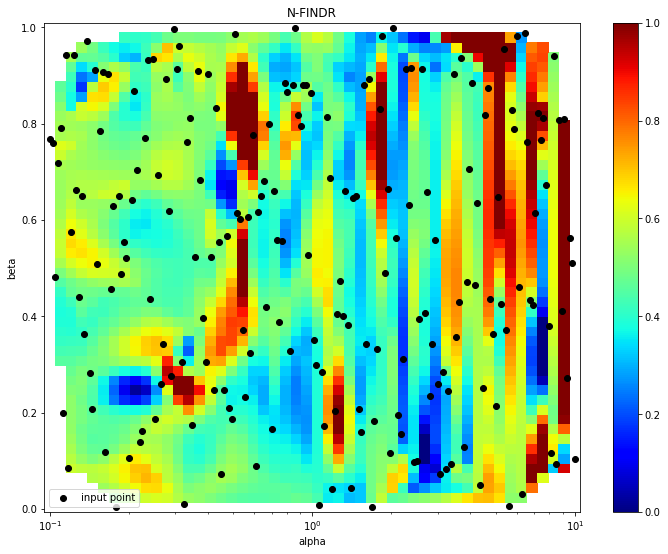

In [36]:
x = alphas
y = betas
z = np.array([np.linalg.norm(score_nfindr(elt)) for elt in res])

X = np.logspace(np.log10(min(x)), np.log10(max(x)))
Y = np.linspace(min(y), max(y))
X, Y = np.meshgrid(X, Y)  # 2D grid for interpolation
interp = CloughTocher2DInterpolator(list(zip(x, y)), z)
#interp = NearestNDInterpolator(list(zip(x, y)), z)
Z = interp(X, Y)


plt.pcolormesh(X, Y, Z, shading='auto', cmap = 'jet', vmin = 0, vmax = 1)
plt.plot(x, y, "ok", label="input point")
plt.legend()
plt.colorbar()
#plt.axis("equal")
plt.xlabel('alpha')
plt.ylabel('beta')
plt.title('N-FINDR')
plt.semilogx()
plt.show()

In [37]:
score_nfindr(res[0])

array([[-0.21623635, -0.31373537],
       [-0.13054466,  0.12960452],
       [ 0.23225927, -0.15612829]], dtype=float32)

In [434]:
closest_permutation_diffs(U, locs)

array([[-0.23506176, -0.21817684],
       [ 0.20596111, -1.4281216 ],
       [-0.21088588, -0.08614886]], dtype=float32)

In [16]:
# data = np.array(res_noise[0]['data']).copy()
# data = np.array(data)[:, None, :]
# nfindr = eea.NFINDR()
# U = nfindr.extract(data, T, maxit=1500, normalize=False, ATGP_init=True)

In [7]:
import dill

# Saved output of the following:
# alphas = np.logspace(-1, 1, 200)

# pyro.set_rng_seed(3)

# res = []
# for a in alphas:
#     res.append(run_instance(a, num_samples = 50, N = 500))

# with open('data/gmm_run_output.dill', 'wb') as f:
#     dill.dump(res, f)

with open('data/gmm_run_output.dill', 'rb') as f:
    res = dill.load(f)
    
alphas = np.array([elt['alpha'] for elt in res])
betas = np.array([elt['beta'] for elt in res])

In [174]:
mkdir data/figs

In [195]:
seed = 3

noises = np.linspace(.01, 3, 50)
noise_scale = 1

def ff(i):
    return plotnfindr(i, save = True, xlim = (-2, 2), ylim = (-2, 1))

res_noise = []
for nscale in noises:
    pyro.set_rng_seed(seed)
    we, locs, data = gen_data(N, alpha = 1, noise_scale= nscale)
    res_noise.append({'we': we, 'data': data, 'locs': locs, 'alpha': a, 'beta': get_beta(*locs)})
    
%matplotlib inline
vis.iplot(ff, res_noise)

interactive(children=(IntSlider(value=24, description='i', max=49), Output(layout=Layout(height='550px'))), _d…

In [170]:
len(noises)

50

In [25]:
pyro.set_rng_seed(3)

noise_scale = 1e-10

res_noise = []
for a in alphas:
    _, locs, data = gen_data(N, alpha = a, noise_scale= noise_scale)
    res_noise.append({'data': data, 'locs': locs, 'alpha': a, 'beta': get_beta(*locs)})
    
%matplotlib inline
vis.iplot(plotnfindr, res_noise)

interactive(children=(IntSlider(value=99, description='i', max=199), Output(layout=Layout(height='550px'))), _…

In [539]:
x = alphas
y = betas
z = np.array([np.linalg.norm(score_nfindr(elt)) for elt in res_noise])

X = np.logspace(np.log10(min(x)), np.log10(max(x)))
Y = np.linspace(min(y), max(y))
X, Y = np.meshgrid(X, Y)  # 2D grid for interpolation
interp = CloughTocher2DInterpolator(list(zip(x, y)), z)
#interp = NearestNDInterpolator(list(zip(x, y)), z)
Z = interp(X, Y)

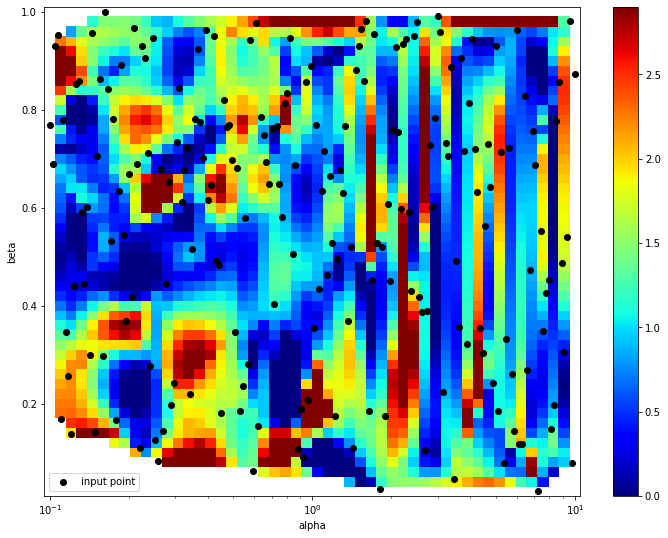

In [540]:
plt.pcolormesh(X, Y, Z, shading='auto', cmap = 'jet', vmin = 0, vmax = 2.9)
plt.plot(x, y, "ok", label="input point")
plt.legend()
plt.colorbar()
#plt.axis("equal")
plt.xlabel('alpha')
plt.ylabel('beta')
plt.semilogx()
plt.show()

In [216]:
U = get_max(nfindr_locs, lambda inp: get_beta(*inp), res_noise[0]['data'])
#nfindr_locs(res_noise[0]['data'])
U

0.9643750398018348


array([[ 0.10259872, -0.21195327],
       [ 1.0455846 ,  0.15879695],
       [ 1.1448426 , -0.7342544 ]], dtype=float32)

In [147]:
# data = res_noise[0]['data']
# data = np.array(data).copy().astype(float)#.swapaxes(0, 1)
# offsets = data.min(axis = 0)

# data = data - offsets

# initial_spectra = np.vstack([data.mean(axis = 0) for _ in range(T)]).astype(float)#np.array(Dirichlet(torch.ones(T)).sample([ndim]).T).astype(float)
# initial_spectra = initial_spectra + np.array([-.1, 0, .1])[:, None]
# assert initial_spectra.shape[1] == ndim

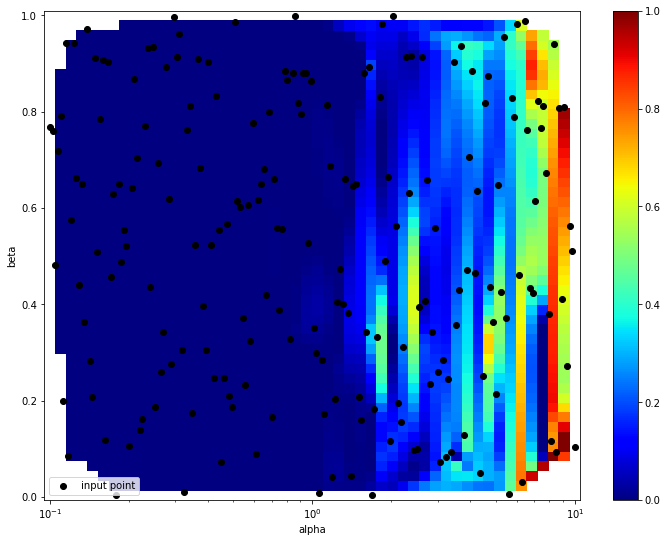

In [39]:
# generate
pyro.set_rng_seed(3)

noise_scale = 1e-10

res_noise = []
for a in alphas:
    _, locs, data = gen_data(N, alpha = a, noise_scale= noise_scale)
    res_noise.append({'data': data, 'locs': locs, 'alpha': a, 'beta': get_beta(*locs)})

# plot
alphas = np.array([elt['alpha'] for elt in res_noise])
betas = np.array([elt['beta'] for elt in res_noise])

x = alphas
y = betas


z = np.array([np.linalg.norm(score_nfindr(elt)) for elt in res_noise])
#z = np.array([np.linalg.norm(get_max(nfindr_locs, lambda inp: get_beta(*inp, norm=False), elt['data'])) for elt in res_noise])

X = np.logspace(np.log10(min(x)), np.log10(max(x)))
Y = np.linspace(min(y), max(y))
X, Y = np.meshgrid(X, Y)  # 2D grid for interpolation
interp = CloughTocher2DInterpolator(list(zip(x, y)), z)
#interp = NearestNDInterpolator(list(zip(x, y)), z)
Z = interp(X, Y)


plt.pcolormesh(X, Y, Z, shading='auto', cmap = 'jet', vmin = 0, vmax = 1)
plt.plot(x, y, "ok", label="input point")
plt.legend()
plt.colorbar()
#plt.axis("equal")
plt.xlabel('alpha')
plt.ylabel('beta')
plt.semilogx()
plt.show()

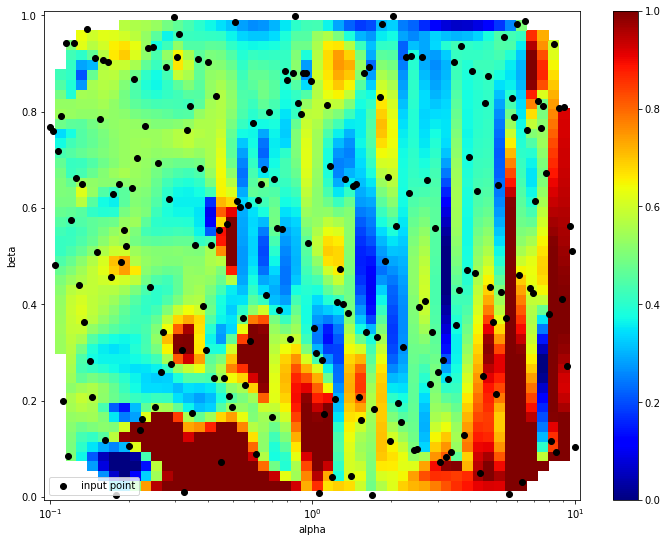

In [29]:
# generate
pyro.set_rng_seed(3)

noise_scale = 1

res_noise = []
for a in alphas:
    _, locs, data = gen_data(N, alpha = a, noise_scale= noise_scale)
    res_noise.append({'data': data, 'locs': locs, 'alpha': a, 'beta': get_beta(*locs)})

# plot
alphas = np.array([elt['alpha'] for elt in res_noise])
betas = np.array([elt['beta'] for elt in res_noise])

x = alphas
y = betas


z = np.array([np.linalg.norm(score_nfindr(elt)) for elt in res_noise])
#z = np.array([np.linalg.norm(get_max(nfindr_locs, lambda inp: get_beta(*inp, norm=False), elt['data'])) for elt in res_noise])

X = np.logspace(np.log10(min(x)), np.log10(max(x)))
Y = np.linspace(min(y), max(y))
X, Y = np.meshgrid(X, Y)  # 2D grid for interpolation
interp = CloughTocher2DInterpolator(list(zip(x, y)), z)
#interp = NearestNDInterpolator(list(zip(x, y)), z)
Z = interp(X, Y)


plt.pcolormesh(X, Y, Z, shading='auto', cmap = 'jet', vmin = 0, vmax = 1)
plt.plot(x, y, "ok", label="input point")
plt.legend()
plt.colorbar()
#plt.axis("equal")
plt.xlabel('alpha')
plt.ylabel('beta')
plt.semilogx()
plt.show()

In [ ]:
seed = 3

noise_scale = 1

alpha_progression = []
for a in alphas:
    pyro.set_rng_seed(seed)
    _, locs, data = gen_data(N, alpha = a, noise_scale= noise_scale)
    alpha_progression.append({'data': data, 'locs': locs, 'alpha': a, 'beta': get_beta(*locs)})

In [166]:
vis.iplot(ploti2, alpha_progression)

interactive(children=(IntSlider(value=99, description='i', max=199), Output(layout=Layout(height='550px'))), _…